In [11]:
import melanoma as mel

%matplotlib inline
%load_ext autoreload
%autoreload -p 2

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

import os
from string import Template

rootpath = '/hpcstor6/scratch01/s/sanghyuk.kim001'
# img_size = (224, 224) # height, width
# img_size = (150, 150) # height, width
utilInstance = mel.Util(rootpath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
SLURM_DIR = '/home/sanghyuk.kim001/MELANOMA/melanoma-detection-CNN/SLURMS'
# if os.path.isExist(SLURM_DIR) is not True:
#     os.makedirs(SLURM_DIR)

# #SBATCH -N 1 # Ensure that all cores are on one machine
# now = "$(date '+%Y%m%d_%H%M%S')"
# #SBATCH -n 2 # Number of cores
# #SBATCH --ntasks=1
# #SBATCH --ntasks-per-gpu=2
# #SBATCH --cpus-per-task=2
# #SBATCH --nodes=2
# #SBATCH --ntasks-per-core=1

# eval "$$(conda shell.bash hook)"
# eval "$$(shell-command)"


# #SBATCH --nodes 1 # Ensure that all cores are on one machine
# #SBATCH --ntasks=4
# #SBATCH --spread-job

# eval "$$(conda shell.bash hook)"
# conda activate clean_chimera_env

# #SBATCH --mem=128gb
# #SBATCH --array=1

# #SBATCH --ntasks-per-node=1
# #SBATCH --ntasks-per-core=1
# #SBATCH --cpus-per-task=1

# #SBATCH --gres=gpu:A100:1

# #SBATCH --nodes=1


SLURM_TEMPLATE = Template('''#!/bin/bash

#SBATCH --job-name=${DBname}_${classifier}_${img_height}h_${img_width}w
#SBATCH -p haehn -q haehn_unlim
#SBATCH -w chimera13

#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem=32gb
#SBATCH --ntasks-per-node=1


#SBATCH --gpus-per-task=1

#SBATCH -t 30-00:00

#SBATCH --output /home/sanghyuk.kim001/MELANOMA/melanoma-detection-CNN/SLURMS/LOGS/%x_%A_%a.out
#SBATCH --error /home/sanghyuk.kim001/MELANOMA/melanoma-detection-CNN/SLURMS/LOGS/%x_%A_%a.err
#SBATCH --array=1
##. /etc/profile,


echo `date`


# For debugging purposes.
python --version
nvcc -V

# Print this sub-job's task ID
echo "My SLURM_ARRAY_TASK_ID: " $SLURM_ARRAY_TASK_ID

cd /home/sanghyuk.kim001/MELANOMA/melanoma-detection-CNN/

export PYTHONUNBUFFERED=TRUE
srun python train.py --DB $db --IMG_SIZE ${img_height} ${img_width} --CLASSIFIER $classifier --JOB_INDEX $SLURM_ARRAY_TASK_ID &
wait

echo "Job ended!"

# end
exit 0;
''')

In [30]:
DBs = [db.name for db in mel.DatasetType]
Classifiers = [c.name for c in mel.NetworkType]

# import pickle
# datum = pickle.load(open('/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB/DenseNet121/_7_point_criteria_150h_150w_binary.pkl', 'rb'))

combinedDBs = {
  # 1 DB
  'HAM10000': [mel.DatasetType.HAM10000.name],
  'ISIC2016': [mel.DatasetType.ISIC2016.name],
  'ISIC2017': [mel.DatasetType.ISIC2017.name],
  'ISIC2018': [mel.DatasetType.ISIC2018.name],
  'ISIC2019': [mel.DatasetType.ISIC2019.name],
  'ISIC2020': [mel.DatasetType.ISIC2020.name],
  # 'PH2': [mel.DatasetType.PH2.name],
  '_7_point_criteria': [mel.DatasetType._7_point_criteria.name],
  'PAD_UFES_20': [mel.DatasetType.PAD_UFES_20.name],
  'MEDNODE': [mel.DatasetType.MEDNODE.name],
  'KaggleMB': [mel.DatasetType.KaggleMB.name],

  # 2 DB
  'ISIC2016+ISIC2017': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name],
  'ISIC2016+ISIC2018': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2018.name],
  'ISIC2016+ISIC2019': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2019.name],
  'ISIC2016+ISIC2020': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2020.name],
  'ISIC2016+PH2': [mel.DatasetType.ISIC2016.name, mel.DatasetType.PH2.name],
  'ISIC2016+_7_point_criteria': [mel.DatasetType.ISIC2016.name, mel.DatasetType._7_point_criteria.name],
  'ISIC2016+PAD_UFES_20': [mel.DatasetType.ISIC2016.name, mel.DatasetType.PAD_UFES_20.name],
  'ISIC2016+MEDNODE': [mel.DatasetType.ISIC2016.name, mel.DatasetType.MEDNODE.name],
  'ISIC2016+KaggleMB': [mel.DatasetType.ISIC2016.name, mel.DatasetType.KaggleMB.name],
  # 3 DBs
  'ISIC2016+ISIC2017+ISIC2018': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name],
  'ISIC2016+ISIC2018+ISIC2019': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name],
  'ISIC2016+ISIC2019+ISIC2020': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name],
  'ISIC2016+ISIC2020+PH2': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name],
  'ISIC2016+PH2+_7_point_criteria': [mel.DatasetType.ISIC2016.name, mel.DatasetType.PH2.name, mel.DatasetType._7_point_criteria.name],
  'ISIC2016+_7_point_criteria+PAD_UFES_20': [mel.DatasetType.ISIC2016.name, mel.DatasetType._7_point_criteria.name, mel.DatasetType.PAD_UFES_20.name],
  'ISIC2016+PAD_UFES_20+MEDNODE': [mel.DatasetType.ISIC2016.name, mel.DatasetType.PAD_UFES_20.name, mel.DatasetType.MEDNODE.name],
  'ISIC2016+MEDNODE+KaggleMB': [mel.DatasetType.ISIC2016.name, mel.DatasetType.MEDNODE.name, mel.DatasetType.KaggleMB.name],

  # 4 DBs
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name],
  'ISIC2016+ISIC2018+ISIC2019+ISIC2020': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name],
  'ISIC2016+ISIC2020+PH2+_7_point_criteria': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name, mel.DatasetType._7_point_criteria.name],
  'ISIC2016+PH2+_7_point_criteria+PAD_UFES_20': [mel.DatasetType.ISIC2016.name, mel.DatasetType.PH2.name, mel.DatasetType._7_point_criteria.name, mel.DatasetType.PAD_UFES_20.name],
  'ISIC2016+_7_point_criteria+PAD_UFES_20+MEDNODE': [mel.DatasetType.ISIC2016.name, mel.DatasetType._7_point_criteria.name, mel.DatasetType.PAD_UFES_20.name, mel.DatasetType.MEDNODE.name],
  'ISIC2016+PAD_UFES_20+MEDNODE+KaggleMB': [mel.DatasetType.ISIC2016.name, mel.DatasetType.PAD_UFES_20.name, mel.DatasetType.MEDNODE.name, mel.DatasetType.KaggleMB.name],

  # 5 DBs
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2020+PH2': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name],
  'ISIC2016+ISIC2017+ISIC2018+PH2+_7_point_criteria': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.PH2.name, mel.DatasetType._7_point_criteria.name],
  'ISIC2016+ISIC2017+ISIC2018+_7_point_criteria+PAD_UFES_20': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType._7_point_criteria.name, mel.DatasetType.PAD_UFES_20.name],
  'ISIC2016+ISIC2017+ISIC2018+PAD_UFES_20+MEDNODE': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.PAD_UFES_20.name, mel.DatasetType.MEDNODE.name],
  'ISIC2016+ISIC2017+ISIC2018+MEDNODE+KaggleMB': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.MEDNODE.name, mel.DatasetType.KaggleMB.name],

  # 6 DBs
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+PH2': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+PH2+_7_point_criteria': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.PH2.name, mel.DatasetType._7_point_criteria.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+_7_point_criteria+PAD_UFES_20': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType._7_point_criteria.name, mel.DatasetType.PAD_UFES_20.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+PAD_UFES_20+MEDNODE': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.PAD_UFES_20.name, mel.DatasetType.MEDNODE.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+MEDNODE+KaggleMB': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.MEDNODE.name, mel.DatasetType.KaggleMB.name],

  # 7 DBs
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+PH2+_7_point_criteria': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name, mel.DatasetType._7_point_criteria.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+_7_point_criteria+PAD_UFES_20': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType._7_point_criteria.name, mel.DatasetType.PAD_UFES_20.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+PAD_UFES_20+MEDNODE': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PAD_UFES_20.name, mel.DatasetType.MEDNODE.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+MEDNODE+KaggleMB': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.MEDNODE.name, mel.DatasetType.KaggleMB.name],

  # 8 DBs
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+PH2+_7_point_criteria+PAD_UFES_20': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name, mel.DatasetType._7_point_criteria.name, mel.DatasetType.PAD_UFES_20.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+PH2+PAD_UFES_20+MEDNODE': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name, mel.DatasetType.PAD_UFES_20.name, mel.DatasetType.MEDNODE.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+PH2+MEDNODE+KaggleMB': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name, mel.DatasetType.MEDNODE.name, mel.DatasetType.KaggleMB.name],

  # 9 DBs
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+PH2+_7_point_criteria+PAD_UFES_20+MEDNODE': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name, mel.DatasetType._7_point_criteria.name, mel.DatasetType.PAD_UFES_20.name, mel.DatasetType.MEDNODE.name],
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+PH2+_7_point_criteria+MEDNODE+KaggleMB': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name, mel.DatasetType._7_point_criteria.name, mel.DatasetType.MEDNODE.name, mel.DatasetType.KaggleMB.name],

  # 10 DBs
  'ISIC2016+ISIC2017+ISIC2018+ISIC2019+ISIC2020+PH2+_7_point_criteria+PAD_UFES_20+MEDNODE+KaggleMB': [mel.DatasetType.ISIC2016.name, mel.DatasetType.ISIC2017.name, mel.DatasetType.ISIC2018.name, mel.DatasetType.ISIC2019.name, mel.DatasetType.ISIC2020.name, mel.DatasetType.PH2.name, mel.DatasetType._7_point_criteria.name, mel.DatasetType.PAD_UFES_20.name, mel.DatasetType.MEDNODE.name, mel.DatasetType.KaggleMB.name],

}


img_size = (150, 150)


# Single DB
# for d in DBs:
#   for c in Classifiers:
#     new_slurm = SLURM_TEMPLATE.substitute(db=[d], memory=32000, img_size=img_size, classifier=c, SLURM_ARRAY_TASK_ID='$SLURM_ARRAY_TASK_ID')
#     slurm_file = os.path.join(SLURM_DIR, d+'_'+c+'.sh')
#     with open(slurm_file, 'w') as f:
#       f.write(new_slurm)

# if len(combinedDBs) == 1:
#   DBname = DB
# elif len(combinedDBs) > 1:
#   DBname = '+'.join(DB)

# Combined DBs
for comb_d in combinedDBs:
  for c in Classifiers:
    DBname = '+'.join(combinedDBs[comb_d])
    new_slurm = SLURM_TEMPLATE.substitute(db=' '.join(combinedDBs[comb_d]), DBname=DBname, img_height=img_size[0], img_width=img_size[1], memory=8000, classifier=c, SLURM_ARRAY_TASK_ID='$SLURM_ARRAY_TASK_ID')
    combinedDB_name = '+'.join(combinedDBs[comb_d])
    slurm_file = os.path.join(SLURM_DIR, combinedDB_name+'_'+c+'.sh')
    with open(slurm_file, 'w') as f:
      f.write(new_slurm)

# slurm_file = os.path.join(SLURM_DIR, DBtemp[0]+'_'+Classifiers_temp[0]+'.sh')
# new_slurm = SLURM_TEMPLATE.substitute(db=d, memory=32000, classifier=c, SLURM_ARRAY_TASK_ID='$SLURM_ARRAY_TASK_ID')
# with open(os.path.join(SLURM_DIR, db+'_'+c+'.sbatch'), 'w') as f:
#   f.write(new_slurm)



In [31]:

# import subprocess
# subprocess.call(['sh', f'./{slurm_file}'])

import itertools
import glob

import os
batches = list(itertools.chain.from_iterable([glob.glob(f'{SLURM_DIR}/*.sh', recursive=True)]))
for b in batches:
    os.system(f'sbatch {b} & wait')


Submitted batch job 310786
Submitted batch job 310787
Submitted batch job 310788
Submitted batch job 310789
Submitted batch job 310790
Submitted batch job 310791
Submitted batch job 310792
Submitted batch job 310793
Submitted batch job 310794
Submitted batch job 310795
Submitted batch job 310796
Submitted batch job 310797
Submitted batch job 310798
Submitted batch job 310799
Submitted batch job 310800
Submitted batch job 310801
Submitted batch job 310802
Submitted batch job 310803
Submitted batch job 310804
Submitted batch job 310805
Submitted batch job 310806
Submitted batch job 310807
Submitted batch job 310808
Submitted batch job 310809
Submitted batch job 310810
Submitted batch job 310811
Submitted batch job 310812
Submitted batch job 310813
Submitted batch job 310814
Submitted batch job 310815
Submitted batch job 310816
Submitted batch job 310817
Submitted batch job 310818
Submitted batch job 310819
Submitted batch job 310820
Submitted batch job 310821
Submitted batch job 310822
S

In [3]:
%run train.py --DB ISIC2016 --IMG_SIZE 150 150 --CLASSIFIER EfficientNetB6 --JOB_INDEX 1

DB: ['ISIC2016']
IMG_SIZE: [150, 150]
CLASSIFIER: EfficientNetB6
JOB_INDEX: 1
Combining...
Combining 1 db out of 1 dbs
Stacking training images
Stacking training labels
Stacking validation images
Stacking validation labels
Combining...
Combining 1 db out of 1 dbs
Stacking training images
Stacking training labels
Stacking validation images
Stacking validation labels
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 2304)              40960143  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1180160   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
________________

KeyboardInterrupt: 

Testing on 7-point-criteria DB
Evaluating ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model on ISIC2018...



2024-02-25 09:13:28.855980: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-02-25 09:13:29.080363: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-25 09:13:29.080408: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (chimerahead.umb.edu): /proc/driver/nvidia/version does not exist
2024-02-25 09:13:29.081700: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 09:13:31.858231: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enab

13/13 [==============================] - 4s 154ms/step - loss: 0.1765 - accuracy: 0.9516
Train loss = 0.17647893726825714  ;  Train accuracy = 95.16%

7/7 [==============================] - 1s 142ms/step - loss: 0.6729 - accuracy: 0.7438
Validation loss = 0.6728742718696594  ;  Validation accuracy = 74.38%

13/13 [==============================] - 2s 158ms/step - loss: 0.4962 - accuracy: 0.7747
Test loss = 0.4962359070777893  ;  Test accuracy = 77.47%
Computing predictions for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 on ISIC2018...
Model report for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model ->


Train Report :
 {'Benign': {'precision': 0.963302752293578, 'recall': 0.9752321981424149, 'f1-score': 0.9692307692307692, 'support': 323}, 'Malignant': {'precision': 0.9069767441860465, 'recall': 0.8666666666666667, 'f1-score': 0.8863636363636364, 'support': 90}, 'accuracy': 0.9515738498789347, 'macro avg': {'precision': 0.9351397482398123, 'recall'

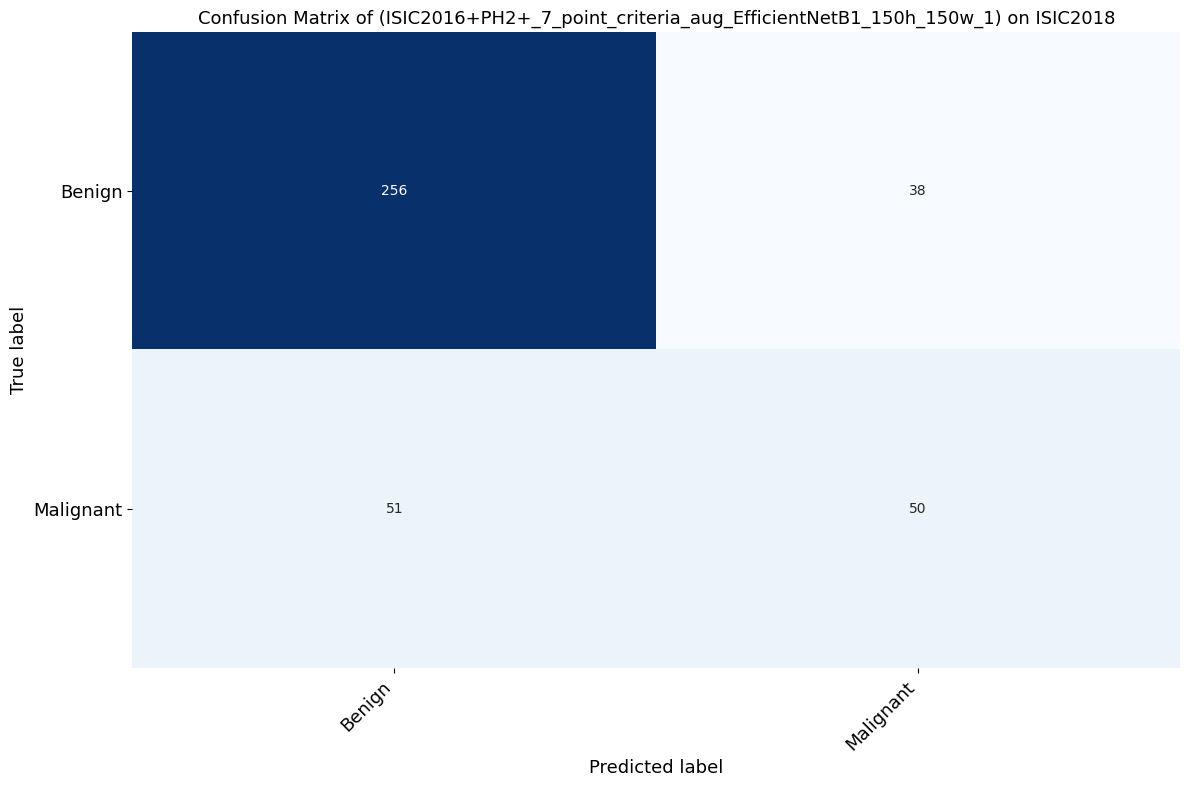

Testing on Kaggle DB
Evaluating ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model on KaggleMB...

66/66 [==============================] - 11s 146ms/step - loss: 0.6321 - accuracy: 0.6880
Train loss = 0.6320751309394836  ;  Train accuracy = 68.80%

17/17 [==============================] - 2s 141ms/step - loss: 0.6112 - accuracy: 0.7197
Validation loss = 0.6111847162246704  ;  Validation accuracy = 71.97%

21/21 [==============================] - 3s 144ms/step - loss: 0.6202 - accuracy: 0.6924
Test loss = 0.6202414035797119  ;  Test accuracy = 69.24%
Computing predictions for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 on KaggleMB...
Model report for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model ->


Train Report :
 {'Benign': {'precision': 0.6615384615384615, 'recall': 0.866783523225241, 'f1-score': 0.7503793626707131, 'support': 1141}, 'Malignant': {'precision': 0.752442996742671, 'recall': 0.4772727272727273, 'f1-score': 0.584

<Figure size 640x480 with 0 Axes>

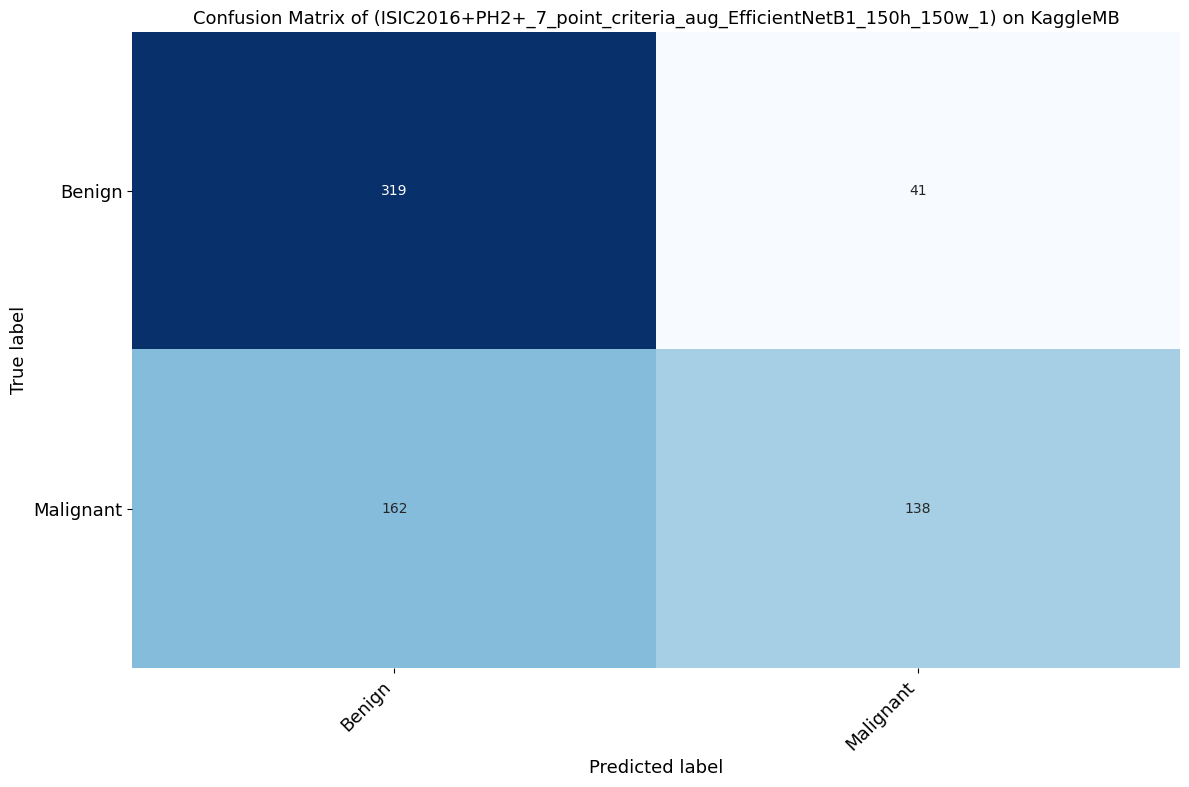

Testing on HAM10000
Evaluating ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model on HAM10000...

251/251 [==============================] - 39s 151ms/step - loss: 0.5187 - accuracy: 0.7644
Train loss = 0.5186892151832581  ;  Train accuracy = 76.44%

28/28 [==============================] - 4s 141ms/step - loss: 0.3997 - accuracy: 0.8414
Validation loss = 0.3996719717979431  ;  Validation accuracy = 84.14%

35/35 [==============================] - 5s 144ms/step - loss: 0.4279 - accuracy: 0.8368
Test loss = 0.4278954863548279  ;  Test accuracy = 83.68%
Computing predictions for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 on HAM10000...
Model report for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model ->


Train Report :
 {'Benign': {'precision': 0.8895846059865608, 'recall': 0.8328567343437232, 'f1-score': 0.8602865160242209, 'support': 6994}, 'Malignant': {'precision': 0.21066846725185687, 'recall': 0.30144927536231886, 'f1-score': 

<Figure size 640x480 with 0 Axes>

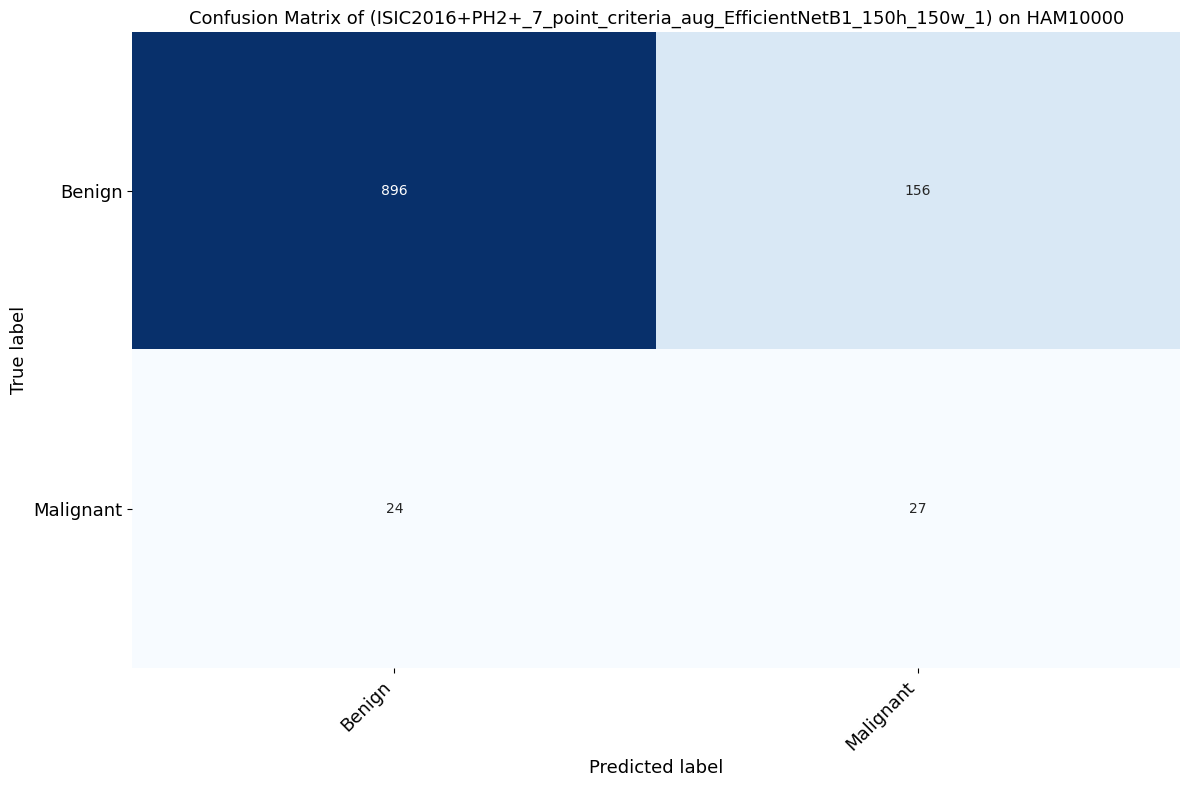

Testing on ISIC2016
Evaluating ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model on ISIC2016...

23/23 [==============================] - 5s 142ms/step - loss: 0.2093 - accuracy: 0.9333
Train loss = 0.2092873752117157  ;  Train accuracy = 93.33%

6/6 [==============================] - 1s 134ms/step - loss: 0.4358 - accuracy: 0.8278
Validation loss = 0.43575841188430786  ;  Validation accuracy = 82.78%

12/12 [==============================] - 2s 145ms/step - loss: 0.4714 - accuracy: 0.7942
Test loss = 0.47135239839553833  ;  Test accuracy = 79.42%
Computing predictions for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 on ISIC2016...
Model report for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model ->


Train Report :
 {'Benign': {'precision': 0.9406919275123559, 'recall': 0.9794168096054888, 'f1-score': 0.9596638655462185, 'support': 583}, 'Malignant': {'precision': 0.8938053097345132, 'recall': 0.7372262773722628, 'f1-score': 0.8079

<Figure size 640x480 with 0 Axes>

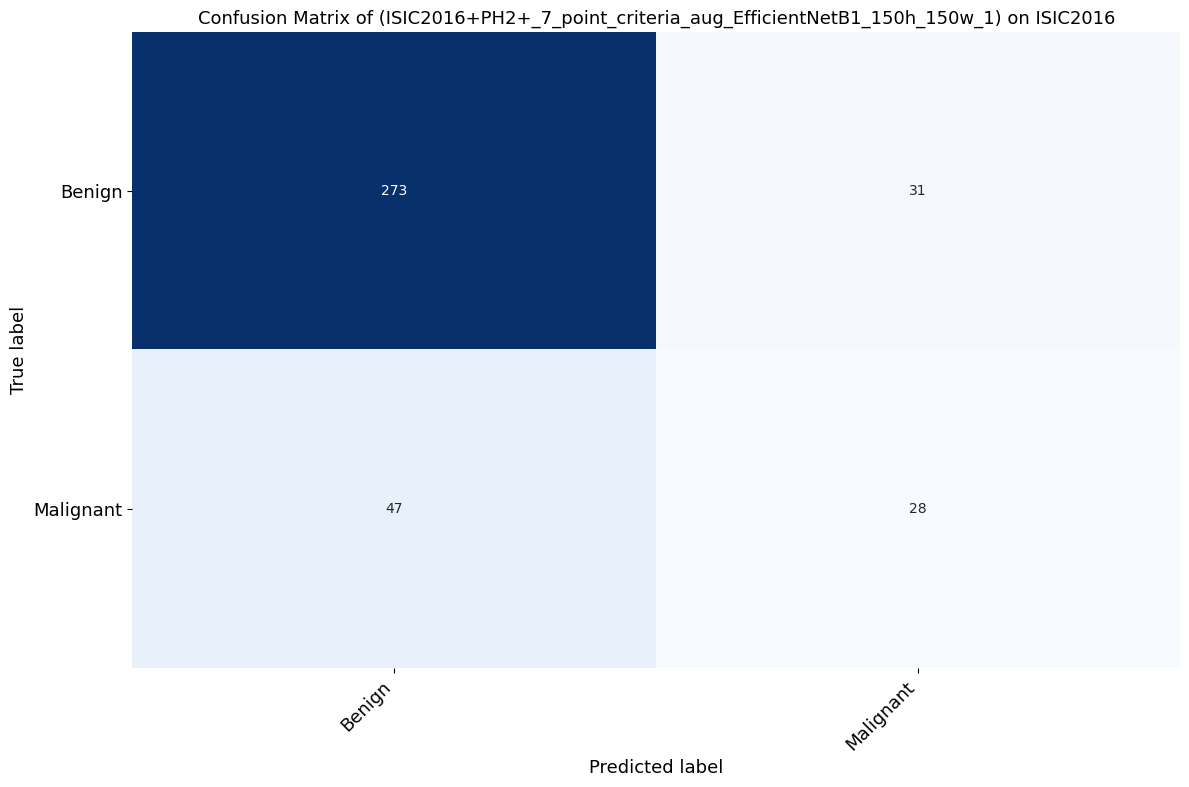

Testing on ISIC2017
Evaluating ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model on ISIC2017...

63/63 [==============================] - 10s 144ms/step - loss: 0.4290 - accuracy: 0.8070
Train loss = 0.4290415644645691  ;  Train accuracy = 80.70%

5/5 [==============================] - 1s 142ms/step - loss: 0.5292 - accuracy: 0.7667
Validation loss = 0.5291897654533386  ;  Validation accuracy = 76.67%

19/19 [==============================] - 3s 143ms/step - loss: 0.5202 - accuracy: 0.7667
Test loss = 0.5201946496963501  ;  Test accuracy = 76.67%
Computing predictions for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 on ISIC2017...
Model report for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model ->


Train Report :
 {'Benign': {'precision': 0.8831891223733004, 'recall': 0.8788437884378844, 'f1-score': 0.8810110974106041, 'support': 1626}, 'Malignant': {'precision': 0.48429319371727747, 'recall': 0.4946524064171123, 'f1-score': 0.489

<Figure size 640x480 with 0 Axes>

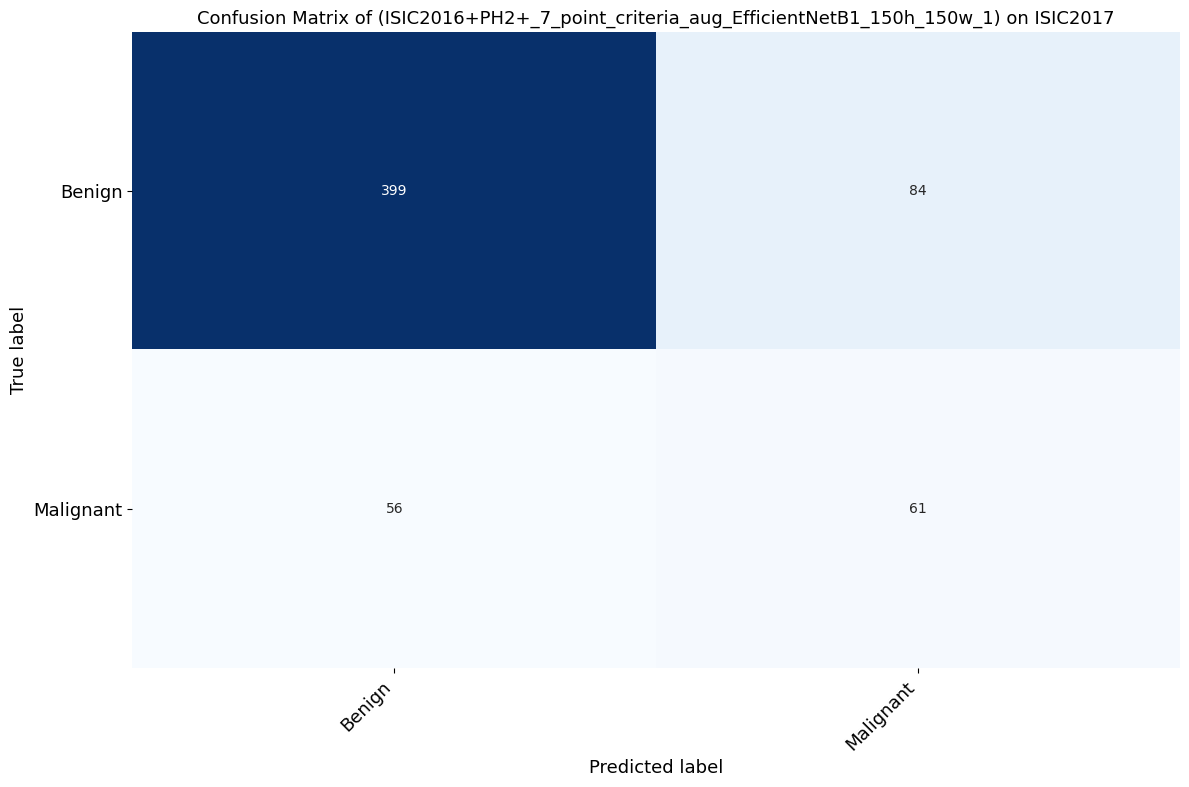

Testing on ISIC2018
Evaluating ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model on ISIC2018...

313/313 [==============================] - 49s 152ms/step - loss: 0.4982 - accuracy: 0.7791
Train loss = 0.4981963634490967  ;  Train accuracy = 77.91%

7/7 [==============================] - 1s 130ms/step - loss: 0.4819 - accuracy: 0.7824
Validation loss = 0.48193204402923584  ;  Validation accuracy = 78.24%

48/48 [==============================] - 7s 146ms/step - loss: 0.5247 - accuracy: 0.7679
Test loss = 0.5247118473052979  ;  Test accuracy = 76.79%
Computing predictions for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 on ISIC2018...
Model report for ISIC2016+PH2+_7_point_criteria_aug_EfficientNetB1_150h_150w_1 model ->


Train Report :
 {'Benign': {'precision': 0.9075292397660819, 'recall': 0.8367782520781847, 'f1-score': 0.870718877849211, 'support': 8902}, 'Malignant': {'precision': 0.19590481460985057, 'recall': 0.31805929919137466, 'f1-score': 0.

<Figure size 640x480 with 0 Axes>

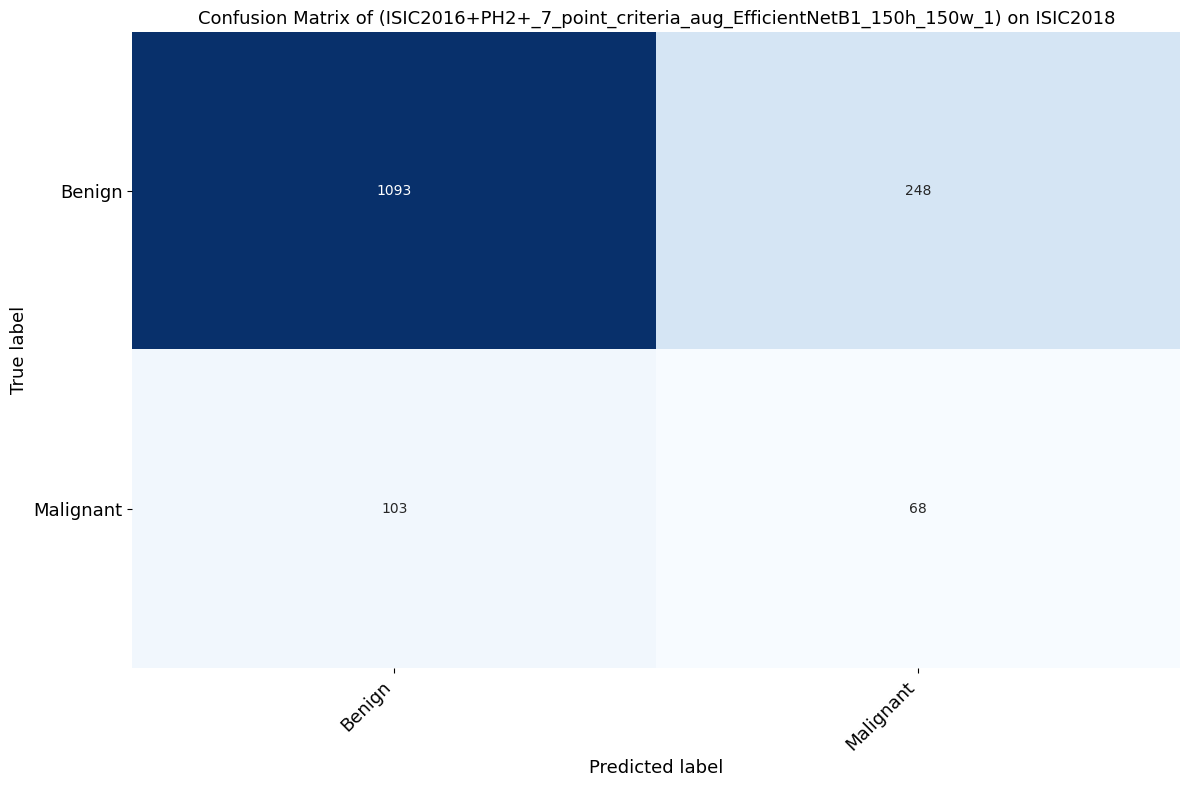

Testing on 7-point-criteria DB
Evaluating ISIC2016+ISIC2018_aug_VGG19_150h_150w_1 model on ISIC2018...

13/13 [==============================] - 8s 575ms/step - loss: 1.1868 - accuracy: 0.6877
Train loss = 1.186797022819519  ;  Train accuracy = 68.77%

7/7 [==============================] - 4s 516ms/step - loss: 1.2982 - accuracy: 0.6897
Validation loss = 1.2982114553451538  ;  Validation accuracy = 68.97%

13/13 [==============================] - 7s 549ms/step - loss: 1.3819 - accuracy: 0.6810
Test loss = 1.3818587064743042  ;  Test accuracy = 68.10%
Computing predictions for ISIC2016+ISIC2018_aug_VGG19_150h_150w_1 on ISIC2018...
Model report for ISIC2016+ISIC2018_aug_VGG19_150h_150w_1 model ->


Train Report :
 {'Benign': {'precision': 0.8344827586206897, 'recall': 0.7492260061919505, 'f1-score': 0.7895595432300164, 'support': 323}, 'Malignant': {'precision': 0.34146341463414637, 'recall': 0.4666666666666667, 'f1-score': 0.3943661971830986, 'support': 90}, 'accuracy': 0.6876513317191

<Figure size 640x480 with 0 Axes>

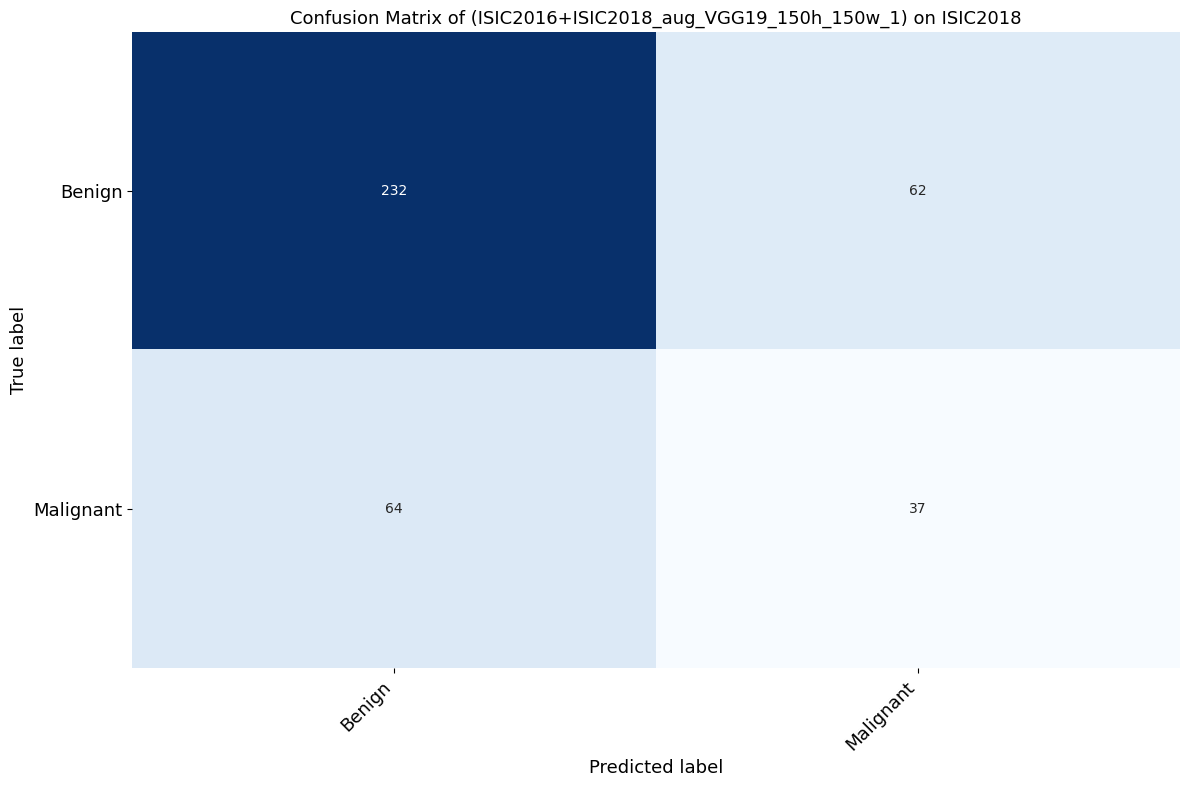

Testing on Kaggle DB
Evaluating ISIC2016+ISIC2018_aug_VGG19_150h_150w_1 model on KaggleMB...

66/66 [==============================] - 38s 579ms/step - loss: 0.8429 - accuracy: 0.7117
Train loss = 0.8428526520729065  ;  Train accuracy = 71.17%

17/17 [==============================] - 10s 564ms/step - loss: 0.7680 - accuracy: 0.7500
Validation loss = 0.7680253982543945  ;  Validation accuracy = 75.00%

21/21 [==============================] - 12s 571ms/step - loss: 0.8141 - accuracy: 0.7227
Test loss = 0.814052164554596  ;  Test accuracy = 72.27%
Computing predictions for ISIC2016+ISIC2018_aug_VGG19_150h_150w_1 on KaggleMB...
Model report for ISIC2016+ISIC2018_aug_VGG19_150h_150w_1 model ->


Train Report :
 {'Benign': {'precision': 0.6541353383458647, 'recall': 0.9912357581069238, 'f1-score': 0.7881533101045297, 'support': 1141}, 'Malignant': {'precision': 0.9736842105263158, 'recall': 0.3822314049586777, 'f1-score': 0.5489614243323442, 'support': 968}, 'accuracy': 0.7117117117117117,

<Figure size 640x480 with 0 Axes>

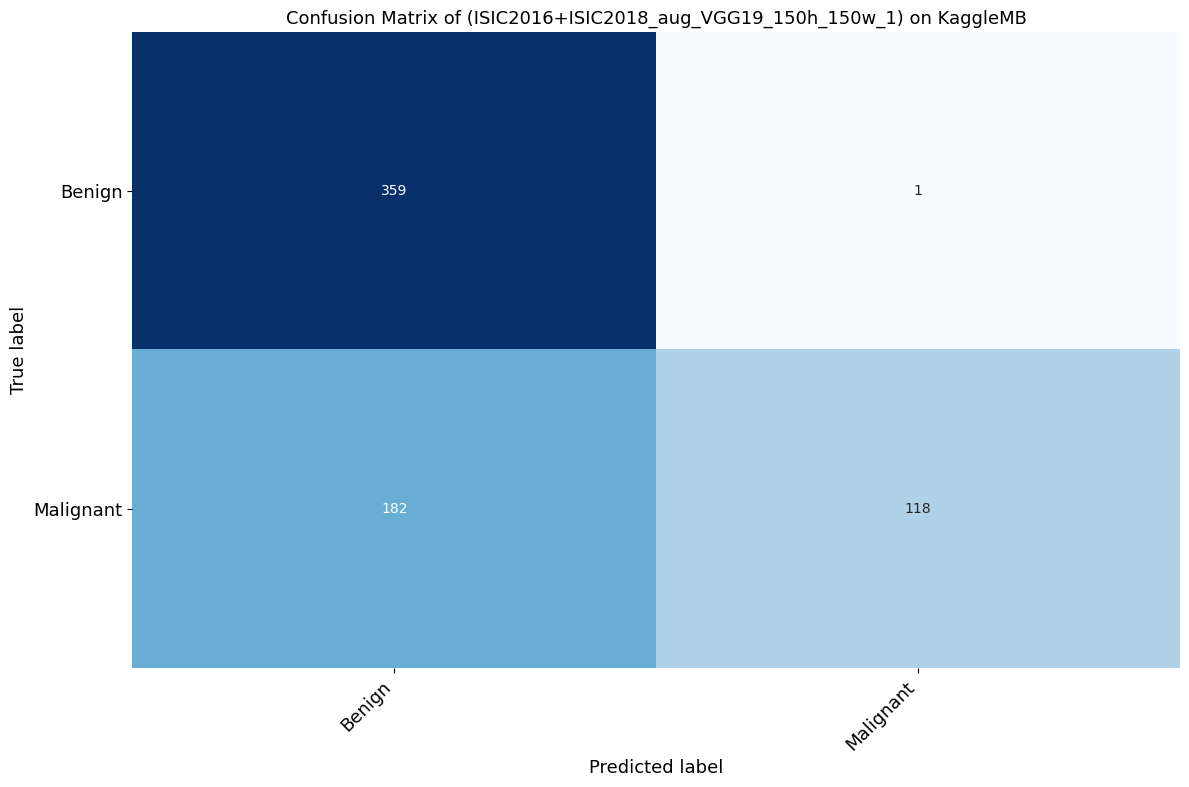

Testing on HAM10000
Evaluating ISIC2016+ISIC2018_aug_VGG19_150h_150w_1 model on HAM10000...

174/251 [===================>..........] - ETA: 44s - loss: 0.1383 - accuracy: 0.9485

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
%run test.py